In [3]:
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier,Pool
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.preprocessing import StandardScaler,RobustScaler,Normalizer
import sklearn
warnings.filterwarnings(action='ignore')

In [4]:
df=pd.read_csv('Heart_num_0228.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274034 entries, 0 to 274033
Data columns (total 47 columns):
 #   Column                                                                       Non-Null Count   Dtype  
---  ------                                                                       --------------   -----  
 0   State                                                                        274034 non-null  int64  
 1   Sex                                                                          274034 non-null  int64  
 2   GeneralHealth                                                                274034 non-null  float64
 3   PhysicalHealthDays                                                           274034 non-null  float64
 4   MentalHealthDays                                                             274034 non-null  float64
 5   LastCheckupTime                                                              274034 non-null  float64
 6   PhysicalActivities          

In [4]:
df.describe()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,CovidPos,"RaceEthnicityCategory_Black only, Non-Hispanic",RaceEthnicityCategory_Hispanic,"RaceEthnicityCategory_Multiracial, Non-Hispanic","RaceEthnicityCategory_Other race only, Non-Hispanic","RaceEthnicityCategory_White only, Non-Hispanic","TetanusLast10Tdap_No, did not receive any tetanus shot in the past 10 years","TetanusLast10Tdap_Yes, received Tdap","TetanusLast10Tdap_Yes, received tetanus shot but not sure what type","TetanusLast10Tdap_Yes, received tetanus shot, but not Tdap"
count,274034.000000,274034.000000,274034.000000,274034.000000,274034.000000,274034.000000,274034.000000,274034.000000,274034.000000,274034.000000,...,274034.000000,274034.000000,274034.000000,274034.000000,274034.000000,274034.000000,274034.000000,274034.000000,274034.000000,274034.000000
mean,27.447065,0.475470,2.461136,4.233347,4.223480,2.670070,0.767711,7.025698,2.318796,0.056340,...,0.599947,0.080384,0.093167,0.022523,0.049505,0.754421,0.339133,0.279535,0.301568,0.079764
std,15.521083,0.499399,1.042482,8.472746,8.140875,0.767337,0.422293,1.455640,0.877973,0.230577,...,0.898081,0.271888,0.290667,0.148376,0.216920,0.430431,0.473416,0.448771,0.458940,0.270928
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.000000,2.000000,0.000000,0.000000,3.000000,1.000000,6.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,3.000000,0.000000,0.000000,3.000000,1.000000,7.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,42.000000,1.000000,3.000000,4.000000,4.000000,3.000000,1.000000,8.000000,3.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,53.000000,1.000000,4.000000,30.000000,30.000000,3.000000,1.000000,24.000000,3.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


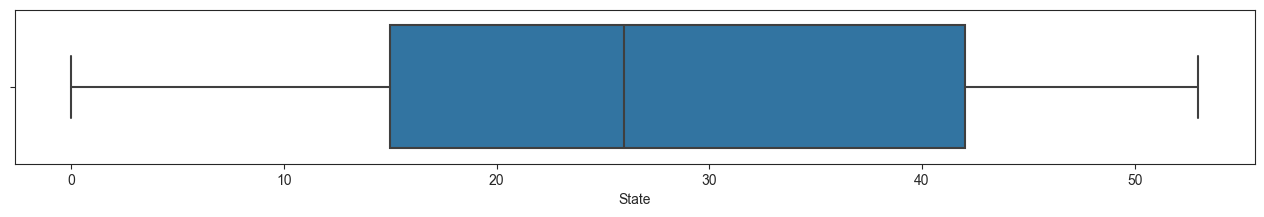

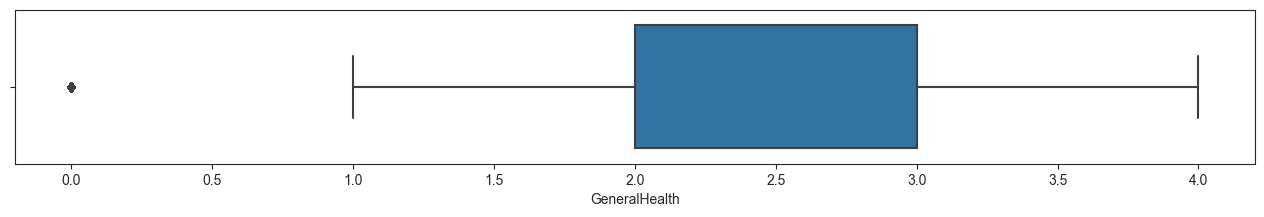

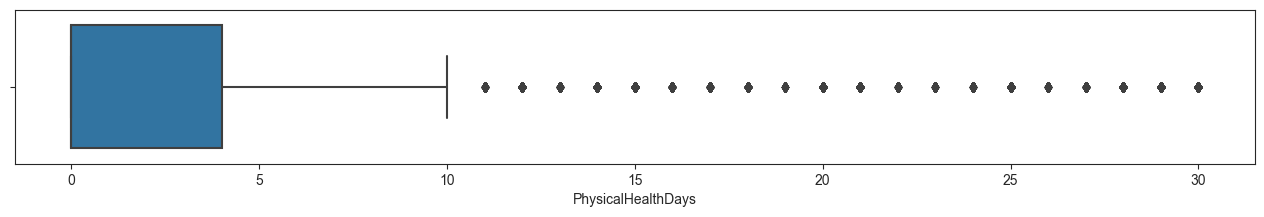

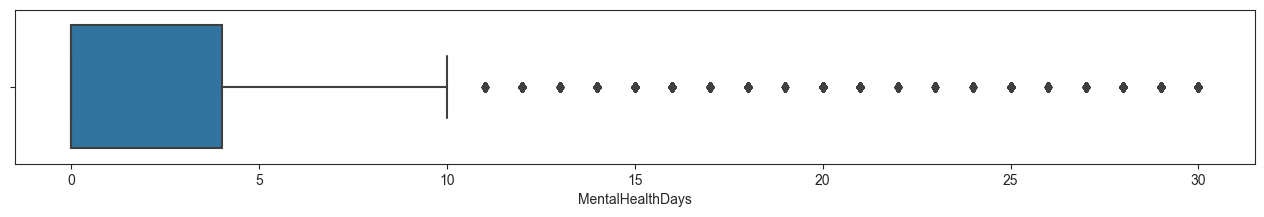

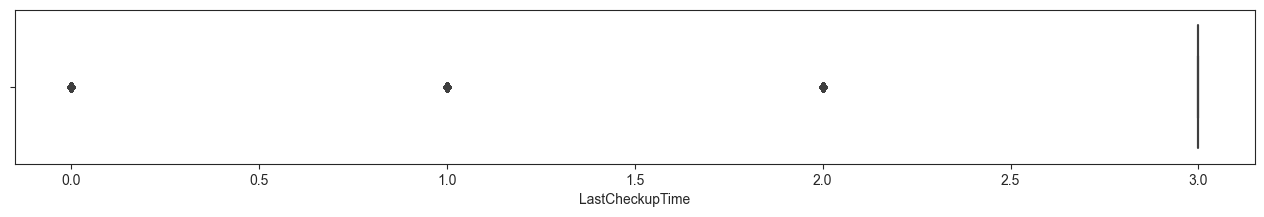

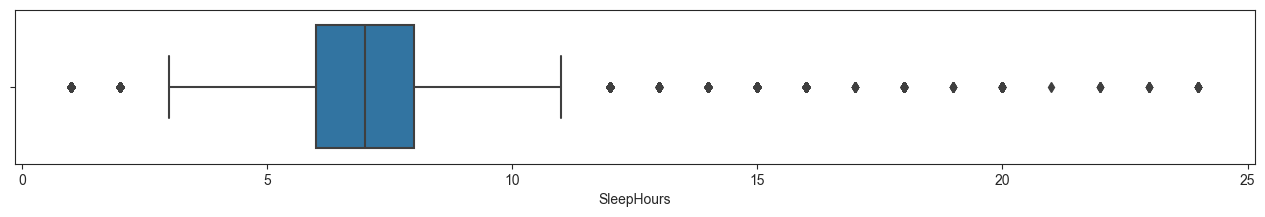

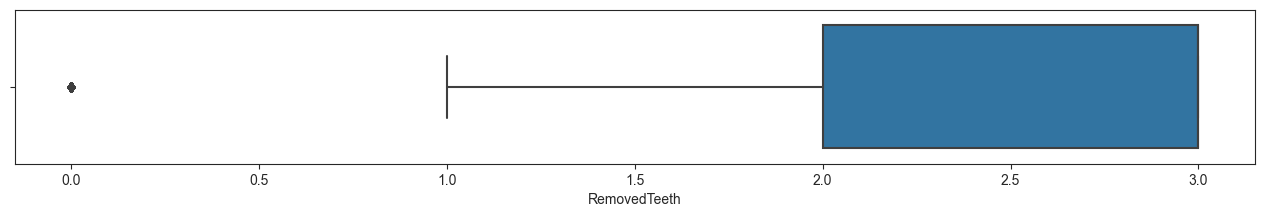

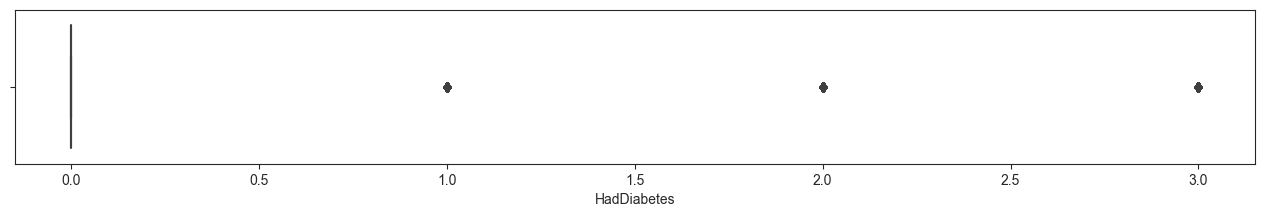

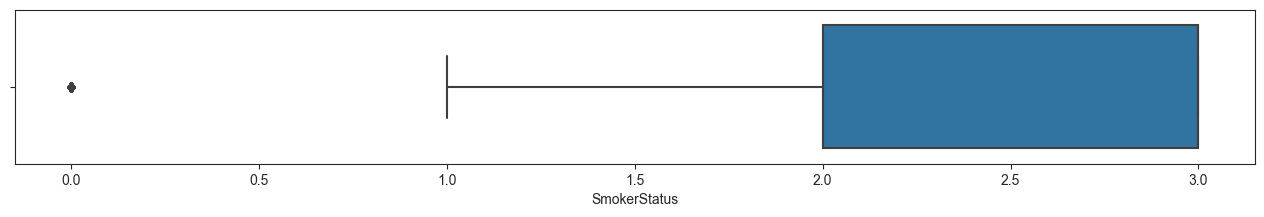

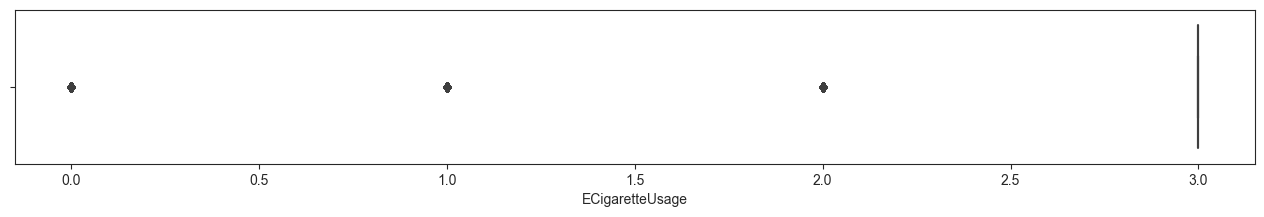

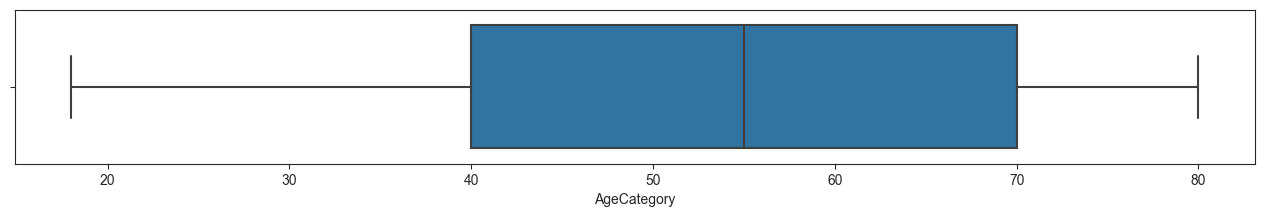

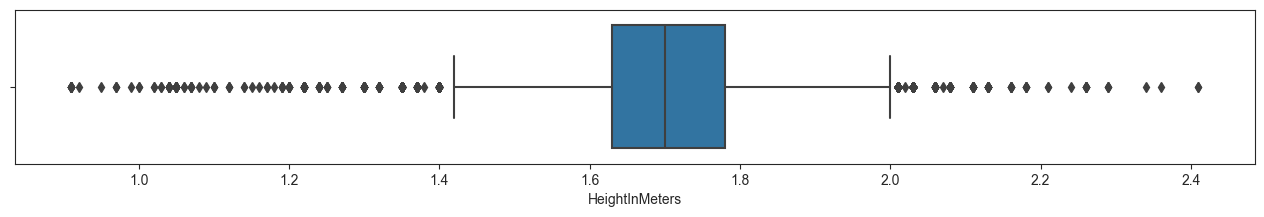

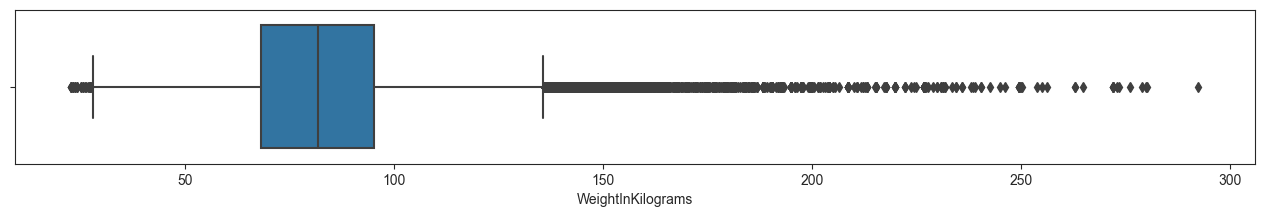

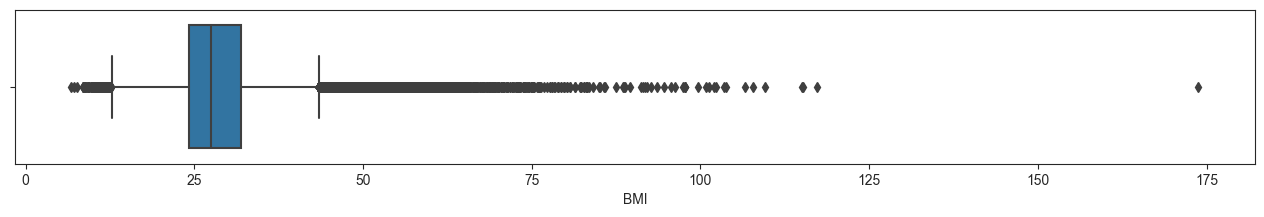

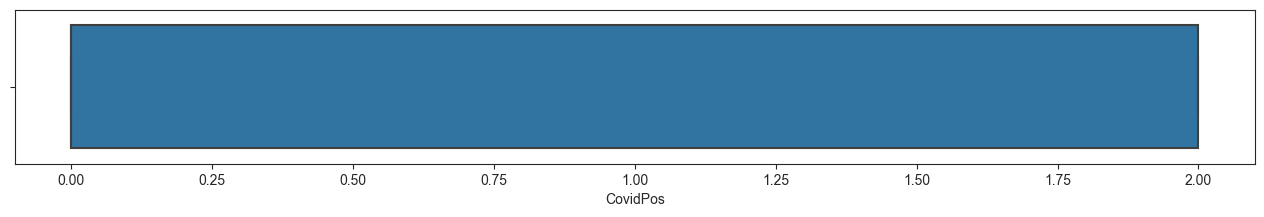

In [5]:
# boxplot을 이용해서 이상치 check
for col in df.columns:
    if len(df[col].unique())>2:
        sns.set_style('ticks')
        plt.figure(figsize=(16,2))
        sns.boxplot(data=df,x=col)
        plt.show()

In [5]:
# outlier check
def get_outlier(col):
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR=Q3-Q1
    lower_limit=Q1-(IQR*1.5)
    upper_limit=Q3+(IQR*1.5)
    outliers=df[(df[col]<lower_limit) | df[col]>upper_limit]
    return outliers,lower_limit,upper_limit

In [6]:
# lower, upper 값 check
sleep_outlier,sleep_lower,sleep_upper=get_outlier('SleepHours')
print(f"Lower Limit:{sleep_lower}\nUpper Limit:{sleep_upper}")

Lower Limit:3.0
Upper Limit:11.0


In [7]:
# lower, upper 값 제거
df.drop(df[df['SleepHours']<3].index,inplace=True)
df.drop(df[df['SleepHours']>11].index,inplace=True)

In [8]:
height_outlier,height_lower,height_upper=get_outlier('HeightInMeters')
print(f'Lower Limit:{height_lower}\nUpper Limit:{height_upper}')

Lower Limit:1.4049999999999998
Upper Limit:2.0050000000000003


In [9]:
df.drop(df[df['HeightInMeters']<height_lower].index,inplace=True)
df.drop(df[df['HeightInMeters']>height_upper].index,inplace=True)
df['HeightInMeters'].unique()

array([1.6 , 1.57, 1.8 , 1.65, 1.63, 1.73, 1.68, 1.55, 1.93, 1.88, 1.7 ,
       1.78, 1.85, 1.75, 1.52, 1.91, 1.96, 1.83, 1.5 , 1.47, 1.42, 1.98,
       1.45, 1.67, 1.51, 1.53, 1.69, 1.56, 1.9 , 1.54, 1.72, 1.87, 1.74,
       1.49, 1.64, 1.58, 1.62, 1.79, 1.46, 1.89, 1.61, 1.77, 1.59, 1.86,
       1.82, 1.66, 1.71, 1.95, 1.76, 1.84, 1.81, 1.44, 1.48, 1.92, 1.43,
       2.  ])

In [10]:
weight_outlier,weight_lower,weight_upper=get_outlier('WeightInKilograms')
print(f'Lower Limit:{weight_lower}\nUpper Limit:{weight_upper}')

Lower Limit:27.225000000000016
Upper Limit:136.065


In [11]:
df.drop(df[df['WeightInKilograms']<weight_lower].index,inplace=True)
df.drop(df[df['WeightInKilograms']>weight_upper].index,inplace=True)
df['WeightInKilograms'].unique()

array([ 68.04,  53.98,  84.82,  62.6 ,  73.48,  59.42,  85.28,  71.21,
        90.72, 107.05,  57.15, 105.23,  77.11,  56.7 ,  79.38,  86.18,
       113.4 , 102.06,  61.23,  59.87,  65.77, 104.33,  81.65,  53.52,
        61.69,  63.5 , 127.01,  78.93,  74.84,  58.97,  92.08,  83.91,
        49.9 , 117.93, 102.97,  62.14,  83.46,  72.57,  54.43,  60.78,
       117.03,  65.32,  89.81,  74.39,  68.95,  79.83, 108.41,  90.26,
        55.79,  78.02,  91.17,  93.89,  95.25,  73.94,  88.9 ,  80.74,
        81.19,  51.71,  76.2 ,  75.3 ,  70.31,  63.05,  82.55,  66.22,
       106.59,  86.64,  84.37, 108.86,  71.67,  92.53, 124.74,  99.79,
        97.52,  63.96,  92.99,  94.35,  44.45, 128.82,  98.88,  45.36,
       110.68,  46.72,  58.06,  73.03,  60.33,  95.71,  88.45, 131.09,
        78.47,  85.73,  67.59, 103.87, 120.2 ,  88.  , 122.47, 115.67,
        54.88, 111.58,  52.16,  77.56, 126.55,  94.8 , 123.83,  50.8 ,
        69.85,  91.63, 112.49,  64.41,  68.49,  82.1 , 106.14,  57.61,
      

In [12]:
df['HeartDisease']=df['HadHeartAttack']|df['HadAngina']
df.drop(['HadHeartAttack','HadAngina'],axis=1,inplace=True)

In [13]:
data=df.drop('HeartDisease',axis=1)
target=df['HeartDisease']

In [14]:
x_train,x_test,y_train,y_test=train_test_split(data,target,test_size=0.2,random_state=1234)

In [15]:
from imblearn.over_sampling import SMOTE
from collections import Counter
smote=SMOTE(k_neighbors=4,random_state=1234)
x_train_r,y_train_r=smote.fit_resample(x_train,y_train)
x_test_r,y_test_r=smote.fit_resample(x_test,y_test)
print('original dataset shape:',Counter(y_train))
print('resample dataset shape:',Counter(y_train_r))

original dataset shape: Counter({0: 191518, 1: 18656})
resample dataset shape: Counter({0: 191518, 1: 191518})


In [16]:
std=StandardScaler()
robust=RobustScaler()
norm=Normalizer()
std_x_train=std.fit_transform(x_train)
robust_x_train=robust.fit_transform(x_train)
norm_x_train=norm.fit_transform(x_train)
std_x_test=std.transform(x_test)
robust_x_test=robust.transform(x_test)
norm_x_test=norm.transform(x_test)

In [17]:
from sklearn.metrics import  accuracy_score, f1_score

In [18]:
def scaler_diff_cat(x_train,x_test,y_train,y_test):
    cat_model=CatBoostClassifier(silent=True)
    cat_model.fit(x_train,y_train)
    pred=cat_model.predict(x_test)
    print(f'f1 score: {f1_score(y_test,pred)}')
    print(f'accuracy score: {accuracy_score(y_test,pred)}')

In [20]:
scaler_diff_cat(std_x_train,std_x_test,y_train,y_test)
scaler_diff_cat(robust_x_train,robust_x_test,y_train,y_test)
scaler_diff_cat(norm_x_train,norm_x_test,y_train,y_test)

f1 score: 0.16958958596998736
accuracy score: 0.9125875456760049
f1 score: 0.16826141902870556
accuracy score: 0.9123211023142509
f1 score: 0.16871387283236994
accuracy score: 0.9124162606577345


In [137]:
scaler_diff_cat(x_train,x_test,y_train,y_test)

f1 score: 0.16826141902870556
accuracy score: 0.9123211023142509


In [21]:
def scaler_diff_tree(x_train,x_test,y_train,y_test):
    tree_model=DecisionTreeClassifier()
    tree_model.fit(x_train,y_train)
    pred=tree_model.predict(x_test)
    print(f'f1 score: {f1_score(y_test,pred)}')
    print(f'accuracy score: {accuracy_score(y_test,pred)}')

In [139]:
scaler_diff_tree(std_x_train,std_x_test,y_train,y_test)
scaler_diff_tree(robust_x_train,robust_x_test,y_train,y_test)
scaler_diff_tree(norm_x_train,norm_x_test,y_train,y_test)

f1 score: 0.2565085771947528
accuracy score: 0.8597746650426309
f1 score: 0.2500755667506297
accuracy score: 0.8583472898903776
f1 score: 0.25020593080724873
accuracy score: 0.8614113885505481


In [140]:
scaler_diff_tree(x_train,x_test,y_train,y_test)

f1 score: 0.25294295200724415
accuracy score: 0.8586898599269184


In [26]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(x_train,y_train)
pred=rf.predict(x_test)
print(f'f1 score: {f1_score(y_test,pred)}')
print(f'accuracy score: {accuracy_score(y_test,pred)}')

f1 score: 0.09480545131345053
accuracy score: 0.912777862362972


In [23]:
# over sampling data
std_x_train_r=std.fit_transform(x_train_r)
robust_x_train_r=robust.fit_transform(x_train_r)
norm_x_train_r=norm.fit_transform(x_train_r)
std_x_test_r=std.transform(x_test_r)
robust_x_test_r=robust.transform(x_test_r)
norm_x_test_r=norm.transform(x_test_r)

In [24]:
# over sampling data score
scaler_diff_cat(std_x_train_r,std_x_test_r,y_train_r,y_test_r)
scaler_diff_cat(robust_x_train_r,robust_x_test_r,y_train_r,y_test_r)
scaler_diff_cat(norm_x_train_r,norm_x_test_r,y_train_r,y_test_r)

f1 score: 0.9486227778863058
accuracy score: 0.9505948653725735
f1 score: 0.9487655325845135
accuracy score: 0.9507305364224587
f1 score: 0.9328853952618589
accuracy score: 0.9355771237737425


In [34]:
scaler_diff_cat(x_train_r,x_test_r,y_train_r,y_test_r)

f1 score: 0.9488014590932777
accuracy score: 0.9507827175954916


In [33]:
scaler_diff_tree(std_x_train_r,std_x_test_r,y_train_r,y_test_r)
scaler_diff_tree(robust_x_train_r,robust_x_test_r,y_train_r,y_test_r)
scaler_diff_tree(norm_x_train_r,norm_x_test_r,y_train_r,y_test_r)

f1 score: 0.901382992139224
accuracy score: 0.9020663744520977
f1 score: 0.9010400252127324
accuracy score: 0.9016906700062617
f1 score: 0.8399848049058447
accuracy score: 0.846138593195575


In [35]:
scaler_diff_tree(x_train_r,x_test_r,y_train_r,y_test_r)

f1 score: 0.9015022586406135
accuracy score: 0.9021498643289502
